In [1]:
import numpy as np 
import matplotlib.pyplot as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal
import time 
#import corner
import h5py
#import ipdb
from scipy import integrate 
#from tqdm import tqdm

# Basic definitions

In [2]:
# magnitude of speed of light
cmag = 149896229 / 500

In [3]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.
zzmin = 0.03
zzmax = 1.7
zbins = zzmin + np.linspace(zzmin, zzmax, 500)


- Import the eigenfunctions from the mathematica output file.

In [5]:
# ## Add code here to read of the e_i eigenvectors
# eigenvectors = [[0] * 850 for _ in range(500)]
# eigenvectors = np.array(eigenvectors)

# eigenvectors = np.loadtxt("/gpfs/home/argiannakopo/cosmo_temp/eigenvectorsFisherTot.dat")
eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot.dat")
eigenvectors.shape

(500, 500)

In [6]:
## Define DE equation of state as a sum over the eigenvectors times some coefficient alpha

# This function returns an array [1, number of z bins] which corresponds DE EoS for each redshift in each bin.
def w(alphas,eigenvectors):
    
    weighted_eigenvectors = alphas[:,np.newaxis] * eigenvectors

    summed_vector = -1 + np.sum(weighted_eigenvectors, axis=0)

    return -1 + summed_vector
    
    

In [7]:
# # Test variables used to make sure things work. They have no meaning.
# testbins = np.linspace(0.01,1,5)
# testalp = np.linspace(0.01, 0.1, 5)
# testvecs = np.array([[1] * 5 for _ in range(5)])
# testsigma2 = np.linspace(0.1,0.2,5)

In [8]:
# def omegade(zbins, alphas, eigenvectors):

#     base = (1 + zbins)
#     power = 3 * ( 1 + w(alphas,eigenvectors))

#     return base ** power

## Different definition to avoid overflow errors
def omegade(zbins, alphas, eigenvectors):
    base = (1 + zbins)
    power = 3 * (1 + w(alphas, eigenvectors))
    
    # Calculate the exponent using logarithm to avoid overflow
    log_result = np.log(base) * power

    # Take the exponent of the result to get the final value
    return np.exp(log_result)
    
    

In [9]:
# ## Different definition to avoid overflow errors
# def omegade(zbins, alphas, eigenvectors):
#     base = (1 + zbins)
#     power = 3 * (1 + w(alphas, eigenvectors))
    
#     # Calculate the exponent using logarithm to avoid overflow
#     log_result = np.log(base) * power

#     # Take the exponent of the result to get the final value
#     return np.exp(log_result)

- The way I defined things, I have an issue with luminosity distance $d_L$ since my bins from summing the eigenvectors go from $z_{min}$ to $z_{max}$ with $z_{min} \neq 0$. However, in the definition of the luminosity distance I have an integral from 0 to z. To deal with this part of $z < z_{min}$, I will evaluate a constant factor with $w_{DE} = w_{fid} = -1$ and add this to each element of the array within the zbins that I care about.


In [10]:
## I need to figure out how to define angular distance 

def hubble(zbins, alphas, eigenvectors, H0, Om, Ok ):

    x = 1 - Om - Ok 
    
    if x < 0:
        print("Error: Bad Input, Om, Ok")
    else:
        return np.array( H0 * np.sqrt( Om * ( 1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * (1 + zbins)**2) )



In [11]:
## Define the comoving distance. 
## Since the zbins start at zmin, I will break the integral in two pieces: [0,zmin) and [zmin,z]

# ## This function return a numpy array that gives the comoving distance at each redshift bin. 
# def comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok):
#     x = 1 - Om - Ok
#     if x < 0:
#         return print('Comoving dist: Bad Input, Om, Ok')
#     else:
#         # Bin the [0, zmin] interval and do the integration
#         x1, x2 = 0, zbins[0]
#         Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#         dx = (x2 - x1) / Nx
#         dz = zbins[1] - zbins[0]
#         less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (H0 * np.sqrt(Om * (1 + x1 + dx * i)**3 + x * (1+ x1 + dx * i) + Ok * (1 + x1 + dx * i)**2)))(i) for i in range(0, Nx))
#         less_zmin =  np.sum(less_zmin_arr)
        
#         return cmag * less_zmin +  cmag * np.cumsum( dz / hubble(zbins, alphas, eigenvectors, H0, Om, Ok))
    
## Define the comoving distance. 
## Since the zbins start at zmin, I will break the integral in two pieces: [0,zmin) and [zmin,z]

## This function return a numpy array that gives the comoving distance at each redshift bin. 
def comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok):
    x = 1 - Om - Ok
    if x < 0:
        return print('Comoving dist: Bad Input, Om, Ok')
    else:
        # Write the comoving distance function for z < zmin where w_de = -1, so that I can use scipy to do the integration for that part
        def f(x1,x, H0, Om, Ok):
            return 1 / ( H0 * np.sqrt( Om * pow(1+x1 ,3 ) + x * (1 + x1) + Ok * pow(1+x1, 2)))
            
        less_zmin = integrate.quad(f, 0, zbins[0], args=(x, H0, Om, Ok))
        # # Bin the [0, zmin] interval and do the integration
        # x1, x2 = 0, zbins[0]
        # Nx = 5 + 5 * int(abs(x2 - x1) * 100)
        # dx = (x2 - x1) / Nx
        dz = zbins[1] - zbins[0]
        # less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (H0 * np.sqrt(Om * (1 + x1 + dx * i)**3 + x * (1+ x1 + dx * i) + Ok * (1 + x1 + dx * i)**2)))(i) for i in range(0, Nx))
        # less_zmin =  np.sum(less_zmin_arr)
       
        return cmag * less_zmin[0] +  cmag * np.cumsum( dz / hubble(zbins, alphas, eigenvectors, H0, Om, Ok))
    
    

In [12]:
## Returns an array of luminosity distances at each redshift z 
def lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok):
    z_shifted = 1 + zbins

    return z_shifted * comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok)
    

In [12]:
# ## Testing
# lum_distance(testbins, testalp, testvecs, 73, 0.24, 0.0)

In [13]:
# Define the logarithm of dL
# Returns the logarithm of the array of luminosity distance for each redshift bin
def log_h0dl(zbins, alphas, eigenvectors, H0, Om, Ok):
    return np.log10( (H0 / cmag) * lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok))
    



In [47]:
# ## Testing
# start_time = time.time()
# x = log_h0dl(testbins, testalp, testvecs, 74, 0.24, 0.0)
# end_time = time.time()
# print("time it took:", end_time - start_time)
# x


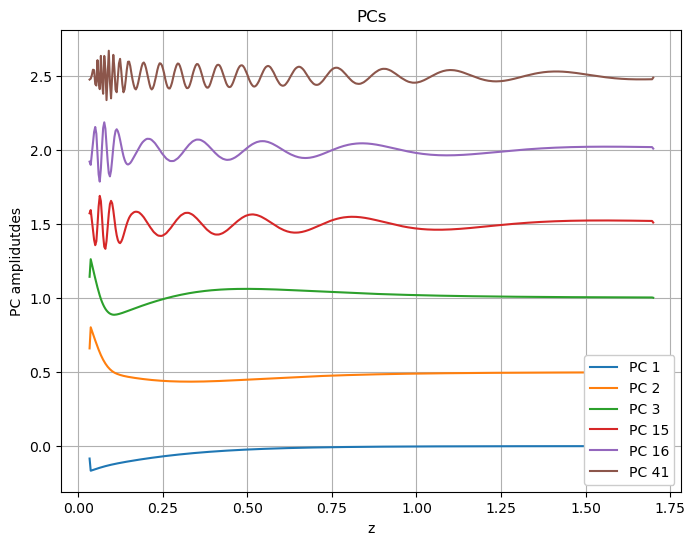

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.0334, 1.7, 500), eigenvectors[0][:], label='PC 1' )
plt.plot(np.linspace(0.0334, 1.7, 500), 0.5 + eigenvectors[1][:], label='PC 2')
plt.plot(np.linspace(0.0334, 1.7, 500), 1 + eigenvectors[2][:], label='PC 3')
plt.plot(np.linspace(0.0334, 1.7, 500), 1.5 + eigenvectors[14][:], label='PC 15')
plt.plot(np.linspace(0.0334, 1.7, 500), 2 + eigenvectors[15][:], label='PC 16')
plt.plot(np.linspace(0.0334, 1.7, 500), 2.5 + eigenvectors[40][:], label='PC 41')
plt.grid()
plt.xlabel('z')
plt.ylabel('PC amplidutdes')
#plt.yscale('log')
plt.title('PCs')
plt.legend(loc='lower right',framealpha=1)
plt.show()

# SN $\sigma^2$ definition

In [48]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0]
zSN = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.75]
SNpoints = list(zip(zSN, NSN))


In [49]:
# Create an interpolation function for the number of SN 

fNSN = interp1d(zSN, NSN, kind='linear', fill_value='extrapolate')


# # Generate new z values for interpolation
# z_values_interpolated = np.linspace(min(zSN), max(zSN), 1000)

# # Interpolate NSN values for the new z values
# NSN_interpolated = fNSN(z_values_interpolated)


In [50]:
zBinsFisher = np.linspace(0.0334, 1.7, 500)

# This function returns the sigma^2 error defined in equation (A2)

def Sigma2SNFisher(i, Nz):        
    zzmin = 0.0334
    zzmax = 1.7
    zBinsFisher = np.linspace(zzmin, zzmax, Nz + 1)

    if i > len(zBinsFisher):
        raise ValueError("Index 'i' is out of range.")

    dz1 = 0.1
    dz2 = 0.07
    tmp = zBinsFisher[1] - zBinsFisher[0]

    z_i = zBinsFisher[i]  

    if z_i < 0.1:
        return dz2 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)
    else:
        return dz1 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)

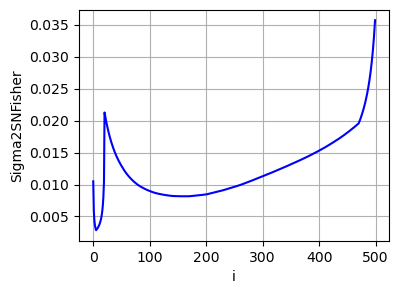

In [51]:
# Test plot to make sure everything works so far

i_values = range(0, len(zBinsFisher))

# Compute Sigma2SNFisher for each i value (each redshift bin of interest)
sigma2_values = [Sigma2SNFisher(i,500) for i in i_values]
sigma2_values = np.array(sigma2_values)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(i_values, sigma2_values, linestyle='-', color='b')
plt.xlabel('i')
plt.ylabel('Sigma2SNFisher')
plt.grid(True)
plt.show()

# SN $\chi^2$ definition

In [52]:
#############################################
### NOT SURE THIS IS NEEDED -- CHECK IT ####
###########################################

# # Interpolate the expressions of the eigenfunctions for the z range that I care about [0.03,1.7]
# eigenvec_interp = [[0] * len(eigenvectors[0]) for _ in range(len(eigenvectors))]

# for i in range(len(eigenvectors)):
#     interp_fun = interp1d(zbins, eigenvectors[i], kind='linear')
#     eigenvec_interp[i] = interp_fun(zBinsFisher)

# eigenvec_interp = np.array(eigenvec_interp)
# eigenvec_interp.shape

Now I have a table 500x500 that only includes the eigenvectors in the redshift range that I am interested in. For the rest I need to use zBinsFisher instead of zbins.

In [53]:
# This function takes as input the zbins, amplitudes alpha, eigenvectors,  error values and cosmo parameters
# and returns the chi^2 based on SN (equation A6 from ref)

def chi_squared_sn(alphas, Om, Omh2, Ok, zBinsFisher, eigenvectors, sigma2_values):
    
    H0 = np.sqrt(Omh2/Om) * 100
    # Difference between MCMC model and fiducial model
    alphas_fid = np.array([0] * len(eigenvectors))
    diff = log_h0dl(zBinsFisher, alphas, eigenvectors, H0, Om, Ok) - log_h0dl(zBinsFisher, alphas_fid, eigenvectors, 73, 0.24, 0.0)

    return 5 * np.sum( diff**2 / sigma2_values) - 25 * np.sum(diff / sigma2_values) / np.sum(1 / sigma2_values)  
    


In [54]:
# ## Testing
# chi_squared_sn(testbins, testalp, testvecs, testsigma2, 73, 0.24, 0.0 )

# Definition of CMB part including radiation

In [55]:
# Define some basic parameters following the PCA construnction

NNU = 3.04
TCMB = 2.725
OGhh = 4.4856e-7 * TCMB ** 4
ONhh = 1.0187e-7 * NNU * TCMB ** 4
ORhh = ONhh + OGhh
zrec = 1090

In [56]:
# covariance matrix
CMBCov = np.array([[0.0018**2, -(0.0014)**2],[-(0.0014)**2, 0.0011**2]])
invCMBCov = np.linalg.inv(CMBCov)

- In this case again I need to be careful how I define the distances because I care about $z_{rec}=1090$.

In [57]:
## I need to figure out how to define angular distance 

def hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh

    if x < 0:
        print("Error: Bad Input, x")
    else:
        return np.array( 100 * np.sqrt( Omh2 * (1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * h2 * (1 + zbins)**3 + ORhh * (1+zbins)**4 ) )



In [58]:
# ## Testing
# hubble_rad(testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0.0, ORhh)

- I need to redefine the comoving distance using the new Hubble function

In [59]:
# ## This function return the comoving distance to redshift z. 
# ## Here I want to extend to redshifts that are zmax of the zbins. 

# def comov_dist_rad(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
#     h2 = Omh2 / Om
#     x = h2 - Omh2 - Ok * h2 - ORhh
    
#     if x < 0:
#         return print('Comoving dist rad: Bad Input, Om, Ok')
#     else:
#         if z < zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, z
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
            
#             return cmag * less_zmin 
            
#         if z <= zbins[-1] and z >= zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
#             # Use boolean mask to only sum up to z and not the rest of the bins. 
#             z_mask = zbins <= z 
            
#             # Discard the z bins that exceed z
#             zbins = zbins[z_mask]
            
#             # Discard the eigenvector bins that exceed z.
#             eigenvectors = eigenvectors[:,:len(zbins)]
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
    
            
#         else:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx *i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)

#             x3, x4 = zbins[-1], z
#             Nx2 = 5 + 5 * int(abs(x4 - x3) * 100)
#             dx2 =(x4 - x3 ) / Nx2
#             larger_zmax_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx2 / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx2))
#             larger_zmax = np.sum(larger_zmax_arr)
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * larger_zmax
            
        

In [60]:
# ## Test
# start_time = time.time()
# x = comov_dist_rad(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("comp time:", end_time - start_time)
# x


- Faster version to compute comoving distance taking into account radiation. 

In [61]:
## This function return the comoving distance to redshift z. 
## I will try different integration methods to speed things up 

#################################################################
##### Comoving distance using the scipy integrate function #####
###############################################################

def comov_dist_rad_fast(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh
    dz = zbins[1] - zbins[0]
    
    if x < 0:
        return print('Comoving dist rad: Bad Input, Om, Ok')
    else:
        def f(x1,x, Ok, h2, ORhh):
            return 1 / (100 * np.sqrt(Omh2 * (1 + x1)**3 + x * (1+ x1) + Ok * h2 * (1 + x1 )**3 + ORhh * (1+ x1 ) ** 4))
    
        if z < zbins[0]:
            return cmag * integrate.quad(f,0, z, args=(x, Ok, h2, ORhh))[0]
                
        if z <= zbins[-1] and z >= zbins[0]:
            z_less = integrate.quad(f,0,zbins[0], args=(x, Ok, h2, ORhh))
            # Use boolean mask to only sum up to z and not the rest of the bins. 
            z_mask = zbins <= z 
            
            # Discard the z bins that exceed z
            zbins = zbins[z_mask]
            
            # Discard the eigenvector bins that exceed z.
            eigenvectors = eigenvectors[:,:len(zbins)]
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
        if z > zbins[-1]:
            z_less = integrate.quad(f,0,zbins[0],args=(x, Ok, h2, ORhh))
            z_more = integrate.quad(f, zbins[-1], z, args=(x, Ok, h2, ORhh))
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * z_more[0]
            
        

In [62]:
# ## Testing
# start_time = time.time()
# x = comov_dist_rad_fast(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

- The $D_a$ function below works correctly only for redshift values z that are larger than the range covered by the SN measurements i.e. larger than $z_{max}$ in $z_{bins}$. However, since I only care about the $z_{rec}$ distance, this is not a problem.

In [63]:
## This function returns the angular distance for redshift z. 
## NOTE: This works for z > zbins interval, but since I am interested in zrec that is okay.
def angular_dist(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    comov_dist = comov_dist_rad_fast(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)
    
    if Ok > 0 :
        return  cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sinh( (1/cmag) * np.sqrt(Ok) * 100 * h2 * comov_dist )   
    
    elif Ok < 0 :
        return cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sin((1/cmag) * np.sqrt(-Ok) * 100 * h2 * comov_dist )
        
    elif Ok == 0:
        return comov_dist / ( 1 + z)
        

In [64]:
# ## Testing
# start_time = time.time()
# x = angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

In [65]:
def ln_angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    return np.log( angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) )

In [66]:
# ## Testing
# start_time = time.time()
# x = ln_angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

# CMB $\chi^2$ definition

In [67]:
## Fiducial model angluar distance to z_rec
alphas_fid = np.array([0] * len(eigenvectors))
lnd_angular_rec_fid = ln_angular_dist(zrec, zbins, alphas_fid, eigenvectors, 0.24 * 0.73**2, 0.24, 0.0, ORhh)

In [68]:
# CMB contribution to χ^2

def chi_squared_cmb(alphas, eigenvectors, invCMBCov, lnd_ang_rec_fid, Omh2, Om, Ok, ORhh):
    zrec = 1090
    Omh2_fid = 0.24 * 0.73 ** 2
    diff1 = ln_angular_dist(zrec, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) - lnd_ang_rec_fid 
    diff2 = Omh2 - Omh2_fid
    

    vec = np.array([diff1, diff2])
    return np.matmul( np.matmul(vec,invCMBCov), vec)   


# Priors

- Refer to equation (A8) from Mortonson et al 0810.1744
- Each one of the priors is written as the logarithm of a Gaussian pdf with variance sigma and mean being the fiducial model. Note that in the definition of the following function I have used the fiducial model values directly, so if I need to redefine which is my fiducial model then I need to revise the definition in this function.

- **For the theoretical prior on the DE equation of state w(z)**
  
We first choose the class of models that we are interested in, i.e. $w_{min} \leq w \leq w_{max}$. Then we need to go through the projection stuff that they describe in the paper such that we extract the resulting constraints on the amplitudes $\alpha_i$. If I want to use the result from the first method that they describe (eq. A(10) in 0810.1744) then I need to know the eigenvectors and I need to sum over all of them. On the other hand, I can be sneaky and use equation (A13) which combines the two methods that they quote. This way I completely avoid dealing with the eigenvectors.

*Is it the case that I don't need to worry about which exactly $\alpha_i$ I am technically sampling from since I can assume that their distributions will be the same? This would also come from the fact that there is a $\mathcal{O}(N_{z,PC})$ symmetry in equation (A13)*

In [36]:
# Angular distance to z=0.35 in the fiducial model
ln_angular_0p35_fid = ln_angular_dist(0.35, zbins, alphas_fid, eigenvectors, 0.24 * 0.73 ** 2, 0.24, 0.0, ORhh)


For the theory prior below, I can rewrite equation (A10) as:

$ \alpha_i^{\pm} = \frac{1}{2N_{z,PC}} \left[ \left( w_{min} + w_{max} - 2 w_{fid} \right) \sum_{j=1}^{N_{z,PC}} e_i (z_j) \pm \left( w_{max} - w_{min} \right) \sum_{j=1}^{N_{z,PC}} \lvert e_i (z_j) \rvert \right]$.

Taking advangate of that, I first calculate the two sums, then weigh the arrays appropriately and sum/take the difference.

In [37]:
## In order to define the correct prior for the PC amplitudes, I need to define the allowed min and max values for each alpha_i.
## I can do that outside of the function that I will write below since these things do not change with each random step that the MCMC makes

# Theoretical limits on DE
wfid = -1
# Quintessence
wmin, wmax = -1, 1
# Smooth DE
# wmin, wmax = -5, 3
weight1 = wmin + wmax - 2 * wfid
weight2 = wmax - wmin 

# First I need to calculate each of the two relevant sums in the eq (A10)
first_sum = np.sum(eigenvectors, axis=1)
second_sum = np.sum(np.abs(eigenvectors), axis=1)

## Nz is the number of z bins I used 
Nz = 500

# alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

- **I will first start by only using the prior on the PCs, not the other ones included in eq. A5 of 0810.1744.**

In [38]:
def chi_squared_prior(alphas, alpha_max, alpha_min):
    if np.any(alphas < alpha_min[:15]) or np.any(alphas > alpha_max[:15]):
        return -np.inf
    return 0 

In [39]:
# # prior 

# def chi_squared_prior(eigenvectors, eigenvectorsNc, alphas, alpha_max, alpha_min, zbins, Omh2, Om, Ok, ORhh, ln_angular_0p35_fid):

# #     # Amplitudes prior 
# #     # Theoretical limits on DE
# #     wfid = -1
# #     # Quintessense 
# #     wmin, wmax = -1, 1
# #     # Smooth DE
# #     # wmin, wmax = -5, 3

# #     weight1 = wmin + wmax - 2 * wfid
# #     weight2 = wmax - wmin 

# #     # First I need to calculate each of the two relevant sums in the eq (A10)
# #     first_sum = np.sum(eigenvectors, axis=1)
# #     second_sum = np.sum(np.abs(eigenvectors), axis=1)
    
# #     # alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
# #     alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
# #     alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

#     # Top hat prior on the amplitudes.
#     # Here I have assumed that I am only intrested in the first 15 alphas i.e. I only want to keep the first 15 eigenfunctions. 
#     # ## NOTE: Be very careful with the definition of the if not statement! 
#     # if  not (np.all(alphas < alpha_max[:2]) and not np.all(alphas > alpha_min[:2])):
#     #     return - np.inf
#     if np.any(alphas < alpha_min[:15]) or np.any(alphas > alpha_max[:15]):
#         return -np.inf
    
#     # h prior
#     sigma_h = 0.08
#     h_prior = -0.5 * ( np.sqrt(Omh2 / Om) - 0.73) ** 2 / sigma_h ** 2
    
#     # BAO prior
#     sigma_bao = 0.037
#     bao_prior = -0.5 * ( ln_angular_dist(0.35, zbins, alphas, eigenvectorsNc, Omh2, Om, Ok, ORhh) - ln_angular_0p35_fid ) ** 2 / sigma_bao ** 2
    
#     # WMAP prior on DE
#     sigma_de = 0.025
#     de_prior = - 0.5 * ( (1 - Om - Ok) - (1 - 0.24)) ** 2 / sigma_de ** 2
    
#     # out = h_prior + bao_prior + de_prior
#     # if (out < 0  and out > -0.05) or out > 10**5:
#     #     print(h_prior, bao_prior, de_prior)
    
#     return h_prior + bao_prior + de_prior   
    

# Uniform Sampling

In [20]:
zBinsFisher = np.linspace(0.0334, 1.7, 500)
## In order to define the correct prior for the PC amplitudes, I need to define the allowed min and max values for each alpha_i.
## I can do that outside of the function that I will write below since these things do not change with each random step that the MCMC makes

# Theoretical limits on DE
wfid = -1
# Quintessence
wmin, wmax = -1, 1
# Smooth DE
# wmin, wmax = -5, 3
weight1 = wmin + wmax - 2 * wfid
weight2 = wmax - wmin 

# First I need to calculate each of the two relevant sums in the eq (A10)
first_sum = np.sum(eigenvectors, axis=1)
second_sum = np.sum(np.abs(eigenvectors), axis=1)

## Nz is the number of z bins I used 
Nz = 500

# alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

In [21]:
alpha_max[0], alpha_min[0]


(0.0, -0.047973273494491604)

- I will sample only for $\alpha_1$, $\Omega_m$ and $\Omega_m h^2$. I will set to zero the rest of the PCs. Also, note that based on the calculation in the previous cell, I know the min and max values that are allowed for $\alpha_1$.
- The following should create two .h5 files that contain the cosmological parameters and the respective values for logdL, so that I can use them for training my ResMLP.

In [22]:
## Define the limits of the sampling region -- ([alphas], Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = np.concatenate([alpha_min[:15],[0.14, 0.055566]])
high_lim = np.concatenate([alpha_max[:15],[0.34, 0.234226]])
# low_lim = [alpha_min[0], 0.14 , 0.055566]
# high_lim = [alpha_max[0], 0.34, 0.234226]


In [35]:
test_vec = np.random.uniform(low=low_lim, high=high_lim, size=None)
test_alps = np.concatenate([test_vec[:15], [0]*485]) 
test_vec

array([-0.01524948, -0.00636062, -0.00131656,  0.03456706,  0.02151446,
        0.02757155,  0.00407498,  0.00541044,  0.02211085,  0.01949988,
       -0.01388144, -0.01948615,  0.03066975,  0.03576192, -0.00527978,
        0.31288681,  0.15547942])

In [39]:
from_alps = log_h0dl(np.linspace(0.0334, 1.7, 500), test_alps, eigenvectors, np.sqrt(test_vec[16]/test_vec[15])*100, test_vec[15],0)


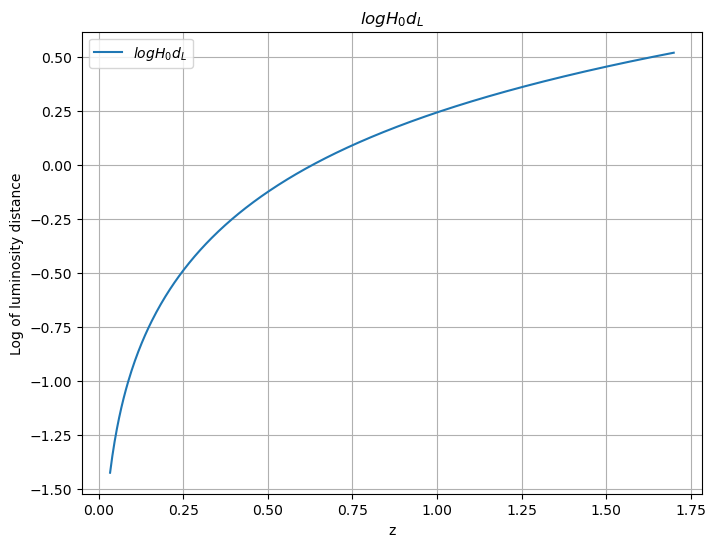

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.0334, 1.7, 500), from_alps, label=r'$logH_0d_L$')

plt.grid()
plt.xlabel('z')
plt.ylabel('Log of luminosity distance')
#plt.yscale('log')
plt.title(r'$logH_0d_L$')
plt.legend()
plt.show()

In [28]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('/gpfs/scratch/argiannakopo/uniform_cosmo_data_15PC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 17), maxshape=(None, 17), dtype=np.float64, chunks=True)

    chunk_size = 100000  # Number of rows per chunk
    for start in range(0, 100000, chunk_size):
        end = min(start + chunk_size, 100000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 17))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk


In [37]:
# Input and output file names
input_filename = '/gpfs/scratch/argiannakopo/uniform_cosmo_data_15PC.h5'
output_filename = '/gpfs/scratch/argiannakopo/uniform_lodL_data_15PC.h5'
zeros = [0] * (500 - 15)

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in range(num_rows):
        row = dataset_in[i]
        alps = np.concatenate([row[:15],zeros])  
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[-1]/row[-2])*100, row[-2], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)


Processing complete. Data saved to: /gpfs/scratch/argiannakopo/uniform_lodL_data_15PC.h5


# Uniform Sampling for the Second PC

In [49]:
## Define the limits of the sampling region -- (alpha_1, Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = [alpha_min[1], 0.14 , 0.055566]
high_lim = [alpha_max[1], 0.34, 0.234226]

In [50]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('uniform_cosmo_data_secondPC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 3), maxshape=(None, 3), dtype=np.float64, chunks=True)

    chunk_size = 1000  # Number of rows per chunk
    for start in tqdm(range(0, 10000, chunk_size)):
        end = min(start + chunk_size, 10000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 3))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk

# Input and output file names
input_filename = 'uniform_cosmo_data_secondPC.h5'
output_filename = 'uniform_lodL_data_secondPC.h5'
zeros = [0] * 499

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in tqdm(range(num_rows)):
        row = dataset_in[i]
        alps = np.insert(zeros, 1, row[0])                
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[2]/row[1])*100, row[1], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.82it/s]

Processing complete. Data saved to: uniform_lodL_data_secondPC.h5


# Uniform Sampling 2 PCs 

In [40]:
## Define the limits of the sampling region -- (alpha_1, Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = [alpha_min[0], alpha_min[1], 0.14 , 0.055566]
high_lim = [alpha_max[0], alpha_max[1], 0.34, 0.234226]

In [41]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('uniform_cosmo_data_2PC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 4), maxshape=(None, 4), dtype=np.float64, chunks=True)

    chunk_size = 1000  # Number of rows per chunk
    for start in tqdm(range(0, 50000, chunk_size)):
        end = min(start + chunk_size, 50000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 4))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2224.55it/s]


In [42]:
# Input and output file names
input_filename = 'uniform_cosmo_data_2PC.h5'
output_filename = 'uniform_lodL_data_2PC.h5'
zeros = [0] * 498

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in tqdm(range(num_rows)):
        row = dataset_in[i]
        alps = np.concatenate([[row[0],row[1]],zeros])                
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[3]/row[2])*100, row[2], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 513.69it/s]

Processing complete. Data saved to: uniform_lodL_data_2PC.h5
